In [1]:
%reset

In [2]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [3]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds
from astropy import units as u


%matplotlib inline

Load Test dataset

In [4]:
## Overall signal
# with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/combined_test_data.pkl', 'rb') as f:
#     photon_info = pickle.load(f) 

# Background signal
with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/test_data_BG.pkl', 'rb') as f:
    photon_info = pickle.load(f) 

Generate Skymap

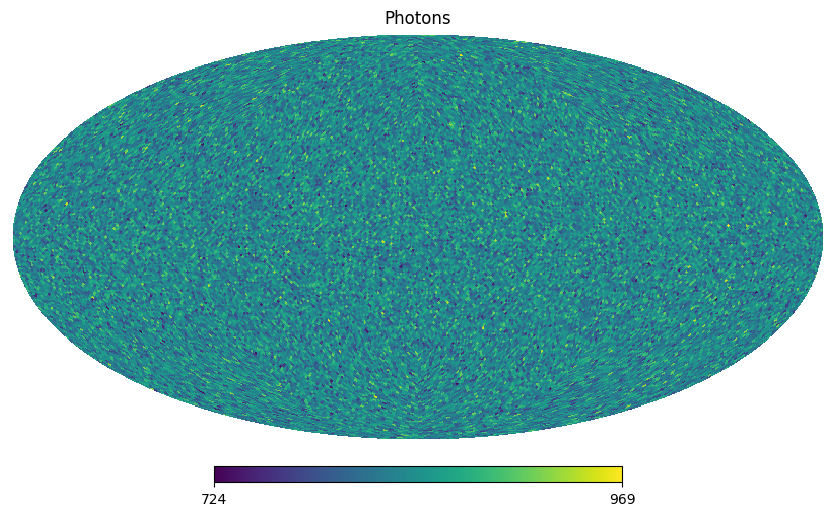

Number of photons in region of interest = 41167024


In [5]:
center_mask = 0 # 60 #deg
lat_mask = 0 # 30 #deg

N_side = 64
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

# Generate a heatmap of the photons
heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), heatmap[0], hp.UNSEEN)
hp.mollview(masked_map, title = 'Photons')
plt.show()

# Compute number of photons in region of interest
photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
roi_mask = np.isin(photon_pixels, roi_pix_i)
energies_in_roi = photon_info['energies'][roi_mask]
print(f"Number of photons in region of interest = {energies_in_roi.size}")